# Forecasting in Vondelpark using Resono data

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Load all the Resono data from 18-10-2020 and filter for one location, in this case Vondelpark West.

In [9]:
path = "Data/Resono/2020-10-18/10/"
filenames = glob.glob(path + "*.csv")
resono_data = pd.concat((pd.read_csv(file) for file in filenames), ignore_index = True)
vondelpark = resono_data[(resono_data['Location'] == 'Vondelpark West')]
vondelpark

,Location,Locationcode,Resono-ID,Start,End,Visits
80,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T00:00:00+00:00,2020-10-10T00:14:59+00:00,47
345,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T00:00:00+00:00,2020-10-10T00:14:59+00:00,47
346,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T00:15:00+00:00,2020-10-10T00:29:59+00:00,92
795,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T00:00:00+00:00,2020-10-10T00:14:59+00:00,47
796,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T00:15:00+00:00,2020-10-10T00:29:59+00:00,92
...,...,...,...,...,...,...
833715,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T22:30:00+00:00,2020-10-10T22:44:59+00:00,157
833716,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T22:45:00+00:00,2020-10-10T22:59:59+00:00,124
833717,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T23:00:00+00:00,2020-10-10T23:14:59+00:00,96
833718,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,rcd23080,2020-10-10T23:15:00+00:00,2020-10-10T23:29:59+00:00,101


Preprocess the data by dropping duplicates, converting the date to datetime and dropping unnecessary columns. For now we only use the time and the amount of visits during that time. 

In [10]:
df = vondelpark.copy()
df = df.drop_duplicates() 
df['datetime'] = pd.to_datetime(df["Start"])
df = df.sort_values(by = 'datetime', ascending = True)
df = df.set_index('datetime')
df = df.drop(['Location', 'Locationcode', 'Resono-ID', 'Start', 'End'], axis=1)
df

,Visits
datetime,
2020-10-10 00:00:00+00:00,47
2020-10-10 00:15:00+00:00,92
2020-10-10 00:30:00+00:00,72
2020-10-10 00:45:00+00:00,55
2020-10-10 01:00:00+00:00,50
...,...
2020-10-10 22:30:00+00:00,157
2020-10-10 22:45:00+00:00,124
2020-10-10 23:00:00+00:00,96


Because this data is formatted as datetime, we use a forecasting model to predict the last two hours of our data. The model is Holt-Winters, so exponential smoothing with seasonal trend, and because our data is collected every 15 minutes, we use a seasonal period of 4.

In [11]:
train = df[:-8]
test = df[-8:]

model = ExponentialSmoothing(np.asarray(train), seasonal_periods=4, trend='add', seasonal='add')
fitted = model.fit()
fc = fitted.forecast(len(test))

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [12]:
fc = pd.DataFrame(fc)
fc["datetime"] = test.index
fc = fc.set_index('datetime')
fc = fc.rename(columns = {0 : "Visits"})
fc

,Visits
datetime,
2020-10-10 22:00:00+00:00,125.401592
2020-10-10 22:15:00+00:00,146.923745
2020-10-10 22:15:00+00:00,140.081402
2020-10-10 22:30:00+00:00,127.579066
2020-10-10 22:45:00+00:00,102.418944
2020-10-10 23:00:00+00:00,123.941096
2020-10-10 23:15:00+00:00,117.098754
2020-10-10 23:30:00+00:00,104.596417


We plot the data and the forecasts to see how our model did. We also calculate the RMSE.

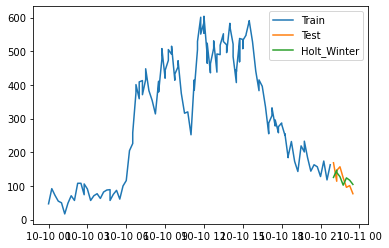

In [13]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(fc, label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [14]:
np.sqrt(mean_squared_error(test, fc))

27.73218857160121